In [1]:
from datasets import load_dataset
import pandas as pd

# 1. Téléchargement du dataset
# Le nom sur le hub est "dair-ai/emotion"
dataset = load_dataset("dair-ai/emotion")

# 2. Aperçu de la structure
print(dataset)

/home/lionel/DEVIA/NLP_/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [23]:
import regex
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    #   * Passage en minuscules.
    text = text.lower()
    #   * Suppression des caractères spéciaux et de la ponctuation (Regex).
    text = regex.sub(r"[^\p{L}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    #   * Suppression des *stopwords* (mots vides sans valeur sémantique).
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
# 2. RETIRER les négations de la liste des mots à supprimer
    negations = {'not', 'no', 'never', 'neither', 'nor', 'none'}
    stop_words = stop_words - negations
    
    # 3. AJOUTER vos mots parasites (ceux qui polluent les clusters)
    custom_excludes = {
        'feel', 'feeling', 'im', 'really', 'day', 'thing', 'got', 'get', 
        'little', 'bit', 'still', 'would', 'ive', 'even', 'make', 'think', 
        'going', 'go', 'know', 'people', 'much', 'something', 'way', 'time',
        'day', 'time', 'week', 'morning', 'night', 'today', 'yesterday',
        'get', 'got', 'go', 'going', 'went', 'come', 'came', 'back', 'make', 'made',
        'think', 'thought', 'know', 'feel', 'feeling', 'want', 'need', 'would',
        'bit', 'little', 'pretty', 'actually', 'really', 'thing', 'something',
        'even', 'still', 'much', 'lot', 'many', 'way', 'people', 'person',
        'ive', 'dont', 'didnt', 'doesnt', 'cant', 'could', 'should',
        'one', 'also', 'back', 'ill', 'every', 'able', 'enough', 'sure', 'maybe', 'perhaps', 'would', 'could', 'should',
    'ive', 'dont', 'didnt', 'doesnt', 'cant', 'like' # On garde 'not' seulement si on utilise des bigrammes, sinon on l'enlève ici

}
    stop_words.update(custom_excludes)
    filtered_tokens = [w for w in tokens if w.lower() not in stop_words and w.isalnum()]
    #   * **Lemmatisation** : ramener les mots à leur racine (ex: *running* -> *run*).
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in filtered_tokens]
    return " ".join(lemmas)


In [24]:
clean_text("i didnt feel humiliated")

'humiliated'

In [25]:
dataset_train = pd.DataFrame(dataset['train'])
dataset_test = pd.DataFrame(dataset['test'])
dataset_validation = pd.DataFrame(dataset['validation'])
dataset_train.head()


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [26]:
from sklearn.utils import resample

# On sépare chaque classe
df_0 = dataset_train[dataset_train['label'] == 0]
df_1 = dataset_train[dataset_train['label'] == 1]
df_2 = dataset_train[dataset_train['label'] == 2]
df_3 = dataset_train[dataset_train['label'] == 3]
df_4 = dataset_train[dataset_train['label'] == 4]
df_5 = dataset_train[dataset_train['label'] == 5]

print(len(df_0))
print(len(df_1))
print(len(df_2))
print(len(df_3))
print(len(df_4))
print(len(df_5))


4666
5362
1304
2159
1937
572


In [27]:
from sklearn.utils import resample

# On cible 1300 exemples par classe
n_target = 1900

df_0_bal = resample(df_0, replace=False, n_samples=n_target, random_state=42)
df_1_bal = resample(df_1, replace=False, n_samples=n_target, random_state=42)
df_3_bal = resample(df_3, replace=False, n_samples=n_target, random_state=42)
df_4_bal = resample(df_4, replace=False, n_samples=n_target, random_state=42)

# Pour les petites (5) : on augmente (Oversampling simple)
df_2_bal = resample(df_2, replace=True, n_samples=n_target, random_state=42)
df_5_bal = resample(df_5, replace=True, n_samples=n_target, random_state=42)

# La classe 2 est déjà à 1304, on la garde telle quelle
df_balanced = pd.concat([df_0_bal, df_1_bal, df_2_bal, df_3_bal, df_4_bal, df_5_bal])

print(df_balanced['label'].value_counts())

label
0    1900
1    1900
2    1900
3    1900
4    1900
5    1900
Name: count, dtype: int64


In [28]:
df_balanced

,text,label
11433,im feeling so lousy they tried to cheer me up ...,0
9343,i feel highly disadvantaged,0
11833,i feel humiliated to introduce you to my colle...,0
88,i feel so worthless during those times i was s...,0
4119,i still miss him and feel rather weepy today,0
...,...,...
2044,i can remember what it feels like to be enthra...,5
10977,i cant help feeling curious you know after all...,5
6359,i have to care about and care for people with ...,5
15380,i have a feeling that my plant may have been t...,5


In [29]:
df_balanced['lemmas'] = df_balanced['text'].apply(clean_text)
dataset_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [30]:
vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, ngram_range=(1, 2))
X = vectorizer.fit_transform(df_balanced['lemmas'])

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=150)
df_balanced['predicted_label'] = kmeans.fit_predict(X)

df_balanced.head()

,text,label,lemmas,predicted_label
11433,im feeling so lousy they tried to cheer me up ...,0,lousy tried cheer school choir practice,1
9343,i feel highly disadvantaged,0,highly disadvantaged,1
11833,i feel humiliated to introduce you to my colle...,0,humiliated introduce colleague wife,1
88,i feel so worthless during those times i was s...,0,worthless time struggling finding work,1
4119,i still miss him and feel rather weepy today,0,miss rather weepy,1


In [32]:
from sklearn.decomposition import TruncatedSVD

# 1. Utiliser TruncatedSVD au lieu de PCA (mieux pour le texte)
# On choisit 3 composantes comme tu le souhaitais
svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(X) # X est ici ta matrice TF-IDF

# 2. On s'assure d'ajouter les coordonnées au BON DataFrame (df_balanced)
# Attention : utilise bien df_balanced car le nombre de lignes doit correspondre à X
df_balanced['x_coord'] = coords[:, 0]
df_balanced['y_coord'] = coords[:, 1]


print("Réduction de dimension terminée !")

Réduction de dimension terminée !


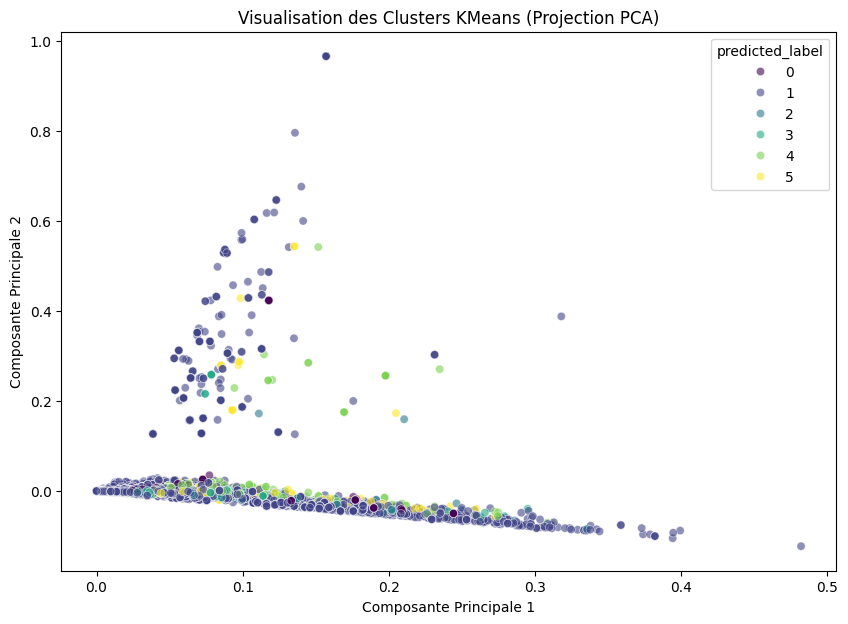

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='x_coord', y='y_coord', 
    hue='predicted_label', # Couleur par cluster
    data=df_balanced, 
    palette='viridis',      # Palette de 6 couleurs
    legend='full',
    alpha=0.6
)

plt.title('Visualisation des Clusters KMeans (Projection PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.show()

In [34]:
terms = vectorizer.get_feature_names_out()

# Accéder aux centroïdes
centroids = kmeans.cluster_centers_

print("--- MOTS LES PLUS PROCHES DES CENTROÏDES ---")
for i in range(6):
    # On trie les indices des poids les plus forts pour le cluster i
    top_indices = centroids[i].argsort()[::-1][:15]
    
    print(f"\nCluster {i} :")
    # Affichage du mot avec son score de proximité (poids TF-IDF moyen)
    report = [f"{terms[ind]} ({centroids[i][ind]:.3f})" for ind in top_indices]
    print(" | ".join(report))

--- MOTS LES PLUS PROCHES DES CENTROÏDES ---

Cluster 0 :
funny (0.363) | not funny (0.033) | not (0.032) | grateful funny (0.023) | feeling funny (0.020) | funny calling (0.020) | hellip (0.018) | feeling (0.018) | grateful (0.018) | calling (0.017) | stomach funny (0.017) | truth (0.015) | started funny (0.015) | story (0.015) | fb (0.015)

Cluster 1 :
not (0.022) | overwhelmed (0.009) | weird (0.009) | life (0.009) | thing (0.007) | strange (0.007) | work (0.007) | no (0.007) | right (0.006) | quite (0.006) | impressed (0.006) | around (0.006) | feeling (0.006) | see (0.006) | friend (0.006)

Cluster 2 :
say (0.280) | not (0.023) | anything (0.018) | no (0.018) | thing (0.017) | impressed (0.016) | must say (0.015) | must (0.014) | guess say (0.014) | ever (0.013) | fear (0.013) | right (0.012) | amazed (0.012) | surprised (0.012) | say impressed (0.012)

Cluster 3 :
amazed (0.116) | make (0.094) | better (0.078) | part (0.060) | life (0.016) | not (0.015) | find (0.013) | often (0.

In [35]:

# On récupère le mot le plus "central" pour chaque cluster
for i in range(6):
    index_central = kmeans.cluster_centers_[i].argmax()
    mot_central = terms[index_central]
    poids_central = kmeans.cluster_centers_[i][index_central]
    
    print(f"Cluster {i} : Le mot 'pilier' est '{mot_central}' (Poids : {poids_central:.4f})")

Cluster 0 : Le mot 'pilier' est 'funny' (Poids : 0.3632)
Cluster 1 : Le mot 'pilier' est 'not' (Poids : 0.0218)
Cluster 2 : Le mot 'pilier' est 'say' (Poids : 0.2804)
Cluster 3 : Le mot 'pilier' est 'amazed' (Poids : 0.1161)
Cluster 4 : Le mot 'pilier' est 'love' (Poids : 0.1646)
Cluster 5 : Le mot 'pilier' est 'always' (Poids : 0.0988)


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Préparation des données (Assurez-vous d'utiliser vos lemmas nettoyés)
# On transforme les listes de mots en chaînes de caractères
X_train = df_balanced['lemmas']
y_train = df_balanced['label']
X_test = dataset_test['text'].apply(clean_text)
y_test = dataset_test['label']


# 3. Vectorisation (Crucial : Bigrammes activés pour le "not")
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Modèle Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# 5. Prédictions
y_pred = model.predict(X_test_tfidf)

In [50]:
print("--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_test, y_pred))

--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       581
           1       0.89      0.85      0.87       695
           2       0.73      0.58      0.65       159
           3       0.72      0.89      0.79       275
           4       0.75      0.87      0.80       224
           5       0.73      0.62      0.67        66

    accuracy                           0.83      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.83      0.83      0.83      2000



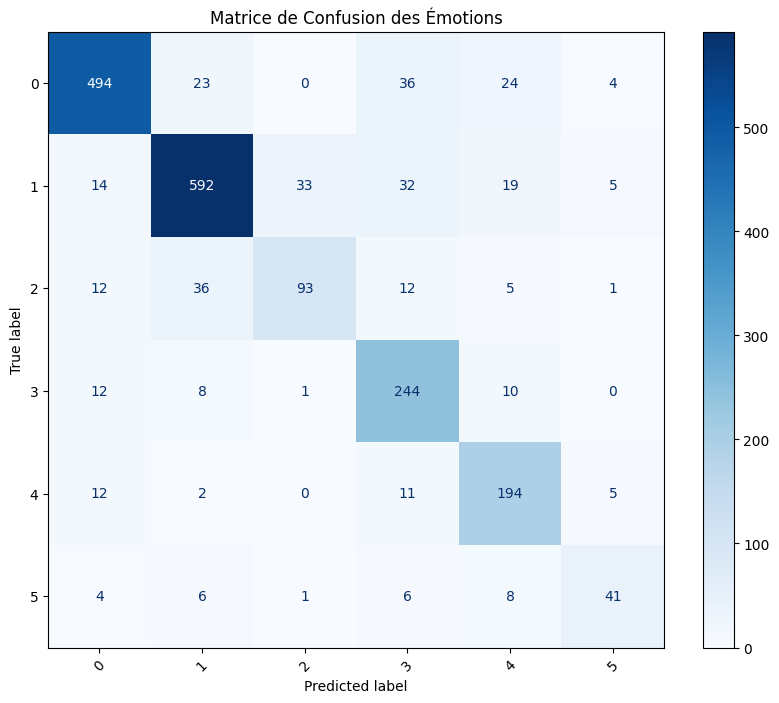

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Matrice de Confusion des Émotions")
plt.show()

In [52]:
test_phrases = [
    "I am overwhelmed with happiness because everything is finally perfect.",
    "It is hard to get out of bed when everything feels so heavy and hopeless.",
    "The way you support me makes me feel so loved and cherished.",
    "I am absolutely fuming! How could they be so incredibly disrespectful?",
    "My heart is racing and I am terrified of what might happen in the dark.",
    "Wow, I am stunned! I never expected this to happen so suddenly.",
    "I am not feeling very glad right now.",
    "This is not a bad day at all."
]
clean_txt_phrases = [clean_text(text) for text in test_phrases]
test_tfidf = vectorizer.transform(clean_txt_phrases)
predictions = model.predict(test_tfidf)

for phrase, pred in zip(test_phrases, predictions):
    print(f"Phrase: '{phrase}' --> Émotion prédite: {pred}")

Phrase: 'I am overwhelmed with happiness because everything is finally perfect.' --> Émotion prédite: 1
Phrase: 'It is hard to get out of bed when everything feels so heavy and hopeless.' --> Émotion prédite: 0
Phrase: 'The way you support me makes me feel so loved and cherished.' --> Émotion prédite: 2
Phrase: 'I am absolutely fuming! How could they be so incredibly disrespectful?' --> Émotion prédite: 4
Phrase: 'My heart is racing and I am terrified of what might happen in the dark.' --> Émotion prédite: 4
Phrase: 'Wow, I am stunned! I never expected this to happen so suddenly.' --> Émotion prédite: 5
Phrase: 'I am not feeling very glad right now.' --> Émotion prédite: 1
Phrase: 'This is not a bad day at all.' --> Émotion prédite: 0


In [53]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Préparation (XGBoost a besoin de labels commençant à 0)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 2. Vectorisation (On garde ta logique de bigrammes)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 3. Configuration du modèle XGBoost
# On utilise 'multi:softmax' pour obtenir directement la classe prédite
model_xgb = xgb.XGBClassifier(
    n_estimators=100,      # Nombre d'arbres
    learning_rate=0.1,     # Vitesse d'apprentissage
    max_depth=6,           # Profondeur des arbres (capture des interactions)
    objective='multi:softmax',
    num_class=len(le.classes_),
    random_state=42
)

# 4. Entraînement
model_xgb.fit(X_train_tfidf, y_train_encoded)

# 5. Prédictions
y_pred_encoded = model_xgb.predict(X_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded) # On revient aux labels d'origine

--- RAPPORT DE CLASSIFICATION (XGBOOST) ---
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       581
           1       0.88      0.87      0.88       695
           2       0.68      0.92      0.78       159
           3       0.86      0.88      0.87       275
           4       0.89      0.85      0.87       224
           5       0.59      0.98      0.74        66

    accuracy                           0.86      2000
   macro avg       0.81      0.89      0.84      2000
weighted avg       0.88      0.86      0.87      2000



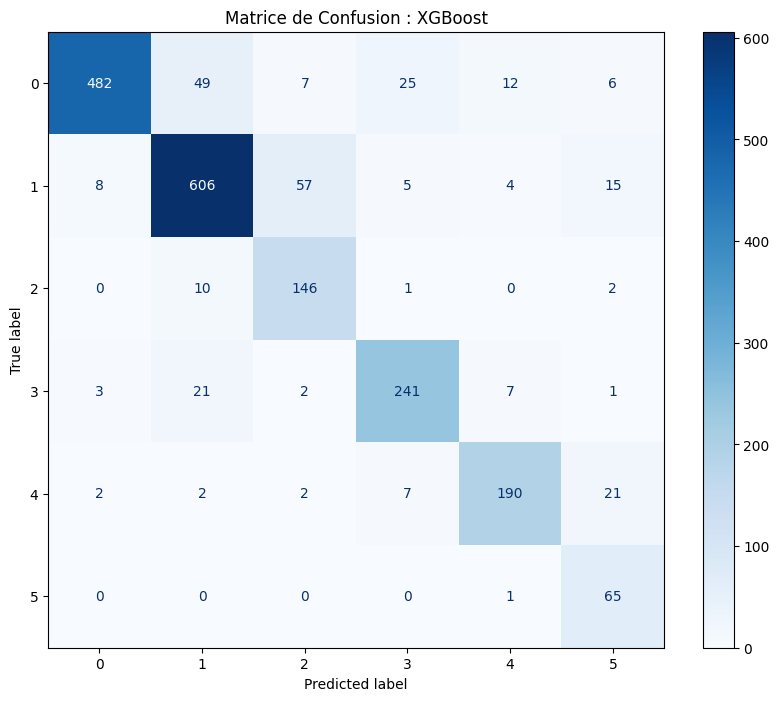

In [54]:
print("--- RAPPORT DE CLASSIFICATION (XGBOOST) ---")
print(classification_report(y_test, y_pred))

# Affichage de la Matrice de Confusion
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title("Matrice de Confusion : XGBoost")
plt.show()

In [58]:
import pandas as pd

emotion_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# On crée un DataFrame de comparaison sur le jeu de test
df_missed = pd.DataFrame({
    'Phrase': dataset_test.loc[X_test.index, 'text'],
    'Vraie_Emotion': y_test.map(emotion_dict),
    'Prediction_IA': pd.Series(y_pred, index=y_test.index).map(emotion_dict)
})

# On ne garde que les lignes où la prédiction est fausse
df_missed = df_missed[df_missed['Vraie_Emotion'] != df_missed['Prediction_IA']]

# Affichons les 10 premières erreurs pour analyse
print(f"Nombre total d'erreurs : {len(df_missed)}")
display(df_missed.head(10))

Nombre total d'erreurs : 270


,Phrase,Vraie_Emotion,Prediction_IA
6,i felt anger when at the end of a telephone call,anger,joy
7,i explain why i clung to a relationship with a...,joy,love
10,i don t feel particularly agitated,fear,anger
20,im not sure the feeling of loss will ever go a...,sadness,love
34,i feel like i m defective or something for not...,sadness,joy
36,i feel very honoured to be included in a magzi...,joy,surprise
55,i have tried to see what it would be like if i...,sadness,love
56,i had every intention of doing more gardening ...,sadness,joy
62,i spent wandering around still kinda dazed and...,joy,surprise
63,i can honestly say that after each sistahs cha...,joy,love


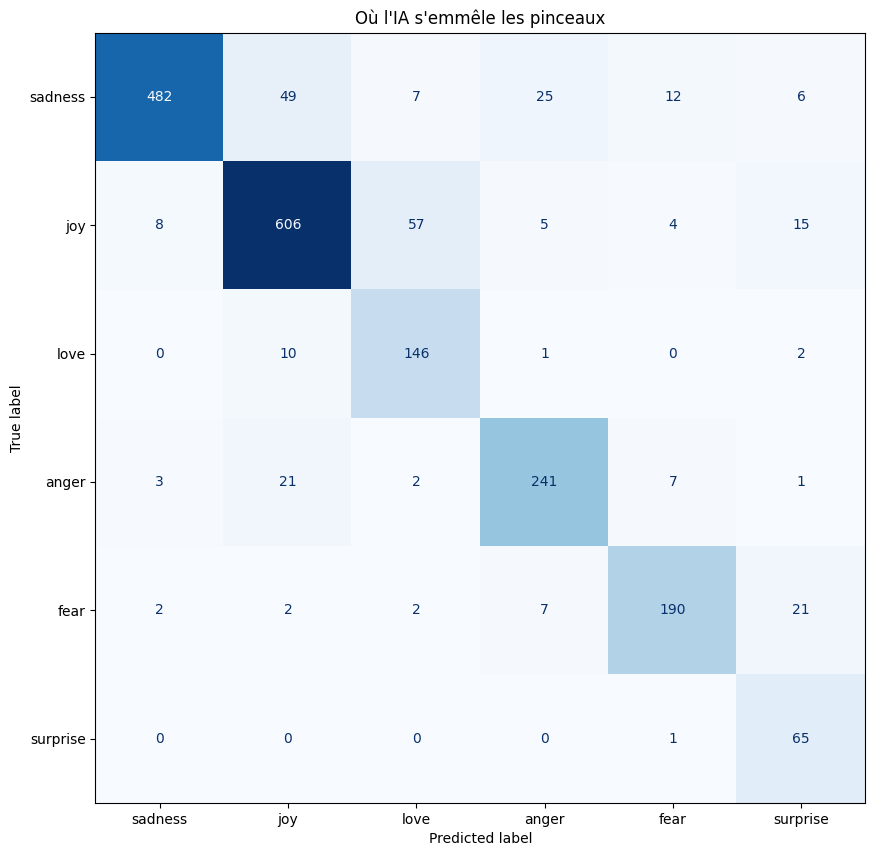

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Utilise ton dictionnaire d'émotions pour les labels
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, 
    display_labels=labels, 
    cmap='Blues', 
    ax=ax, 
    colorbar=False
)
plt.title("Où l'IA s'emmêle les pinceaux")
plt.show()